## Importing python packages

In [142]:
!pip install missingno
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.2/396.2 kB 3.8 MB/s eta 0:00:000:00:010:00:01


In [145]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import ruptures as rpt
import numpy as np

## Importing the data

In [189]:
raw_us_confirmed_cases = pd.read_csv(os.path.join("..","data","RAW_us_confirmed_cases.csv"))
mask_use_by_county = pd.read_csv(os.path.join("..","data","mask-use-by-county.csv"))
mask_mandates_april_2020_aug_2021 = pd.read_csv(os.path.join("..","data","U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv"))

## Data Cleaning

### Total COVID Cases in Cook county of Illinois state

In [163]:
raw_cook_confirmed_cases = raw_us_confirmed_cases[(raw_us_confirmed_cases["Province_State"] == "Illinois") & (raw_us_confirmed_cases["Admin2"] == "Cook")]
# Excluding first 12 columns as its general info about the state
cook_general_info = raw_cook_confirmed_cases[raw_cook_confirmed_cases.columns[0:12]]
# Required later
COOK_FIPS = cook_general_info["FIPS"].values[0]
#lets take all the columns with confirmed cases by date and pivot the table + make the date its own column. Schema of date, confirmed cases
cook_confirmed_cases_by_date =  raw_cook_confirmed_cases[raw_cook_confirmed_cases.columns[12:]]
cook_confirmed_cases_by_date = pd.DataFrame(cook_confirmed_cases_by_date.iloc[0])
cook_confirmed_cases_by_date = cook_confirmed_cases_by_date.reset_index()
cook_confirmed_cases_by_date.columns = ["date", "confirmed_cases"]

In [164]:
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
cook_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == COOK_FIPS]
cook_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "IL") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Cook County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")

/var/folders/qg/w9c0ll710y55hfpbqgzd50h00000gn/T/xpython_72671/478671057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")


In [165]:
cook_confirmed_cases_by_date['date'] = pd.to_datetime(cook_confirmed_cases_by_date['date'])
cook_confirmed_cases_by_date = cook_confirmed_cases_by_date[(cook_confirmed_cases_by_date['date'] >= '2020-02-01')
                                                            & (cook_confirmed_cases_by_date['date'] <= '2021-10-01')]
cook_confirmed_cases_by_date = cook_confirmed_cases_by_date.set_index('date')
cook_confirmed_cases_by_date

,confirmed_cases
date,
2020-02-01,2
2020-02-02,2
2020-02-03,2
2020-02-04,2
2020-02-05,2
...,...
2021-09-27,617360
2021-09-28,617846
2021-09-29,618610


### Mask mandate data

In [186]:
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
cook_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == COOK_FIPS]
cook_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "IL") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Cook County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")
cook_mask_mandates_april_2020_aug_2021 = cook_mask_mandates_april_2020_aug_2021[["date","Face_Masks_Required_in_Public"]]
cook_mask_mandates_april_2020_aug_2021['date'] = pd.to_datetime(cook_mask_mandates_april_2020_aug_2021['date'])
cook_mask_mandates_april_2020_aug_2021 = cook_mask_mandates_april_2020_aug_2021.set_index('date')
cook_mask_mandates_april_2020_aug_2021.head()

/var/folders/qg/w9c0ll710y55hfpbqgzd50h00000gn/T/xpython_72671/2711864994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = cook_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")
/var/folders/qg/w9c0ll710y55hfpbqgzd50h00000gn/T/xpython_72671/2711864994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cook_mask_mandates_april_2020_aug_2021['date'] = pd.to_datetime(cook_mask_mandates_april_2020_aug_202

,Face_Masks_Required_in_Public
date,
2020-04-10,No
2020-04-11,No
2020-04-12,No
2020-04-13,No
2020-04-14,No


## Covid cases datasets combined with Mask Mandate information

In [170]:
df_combined = pd.merge(cook_confirmed_cases_by_date, cook_mask_mandates_april_2020_aug_2021, how = 'left', left_index = True, right_index = True)
df_combined = df_combined.rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})
df_combined.head()

,confirmed_cases,mask_required
date,,
2020-02-01,2,NaN
2020-02-02,2,NaN
2020-02-03,2,NaN
2020-02-04,2,NaN
2020-02-05,2,NaN


### Missing values have been introduced in above merged data. Using missingno package to understand distribution of missing values in mask_required column to understand the reason.

<AxesSubplot: >

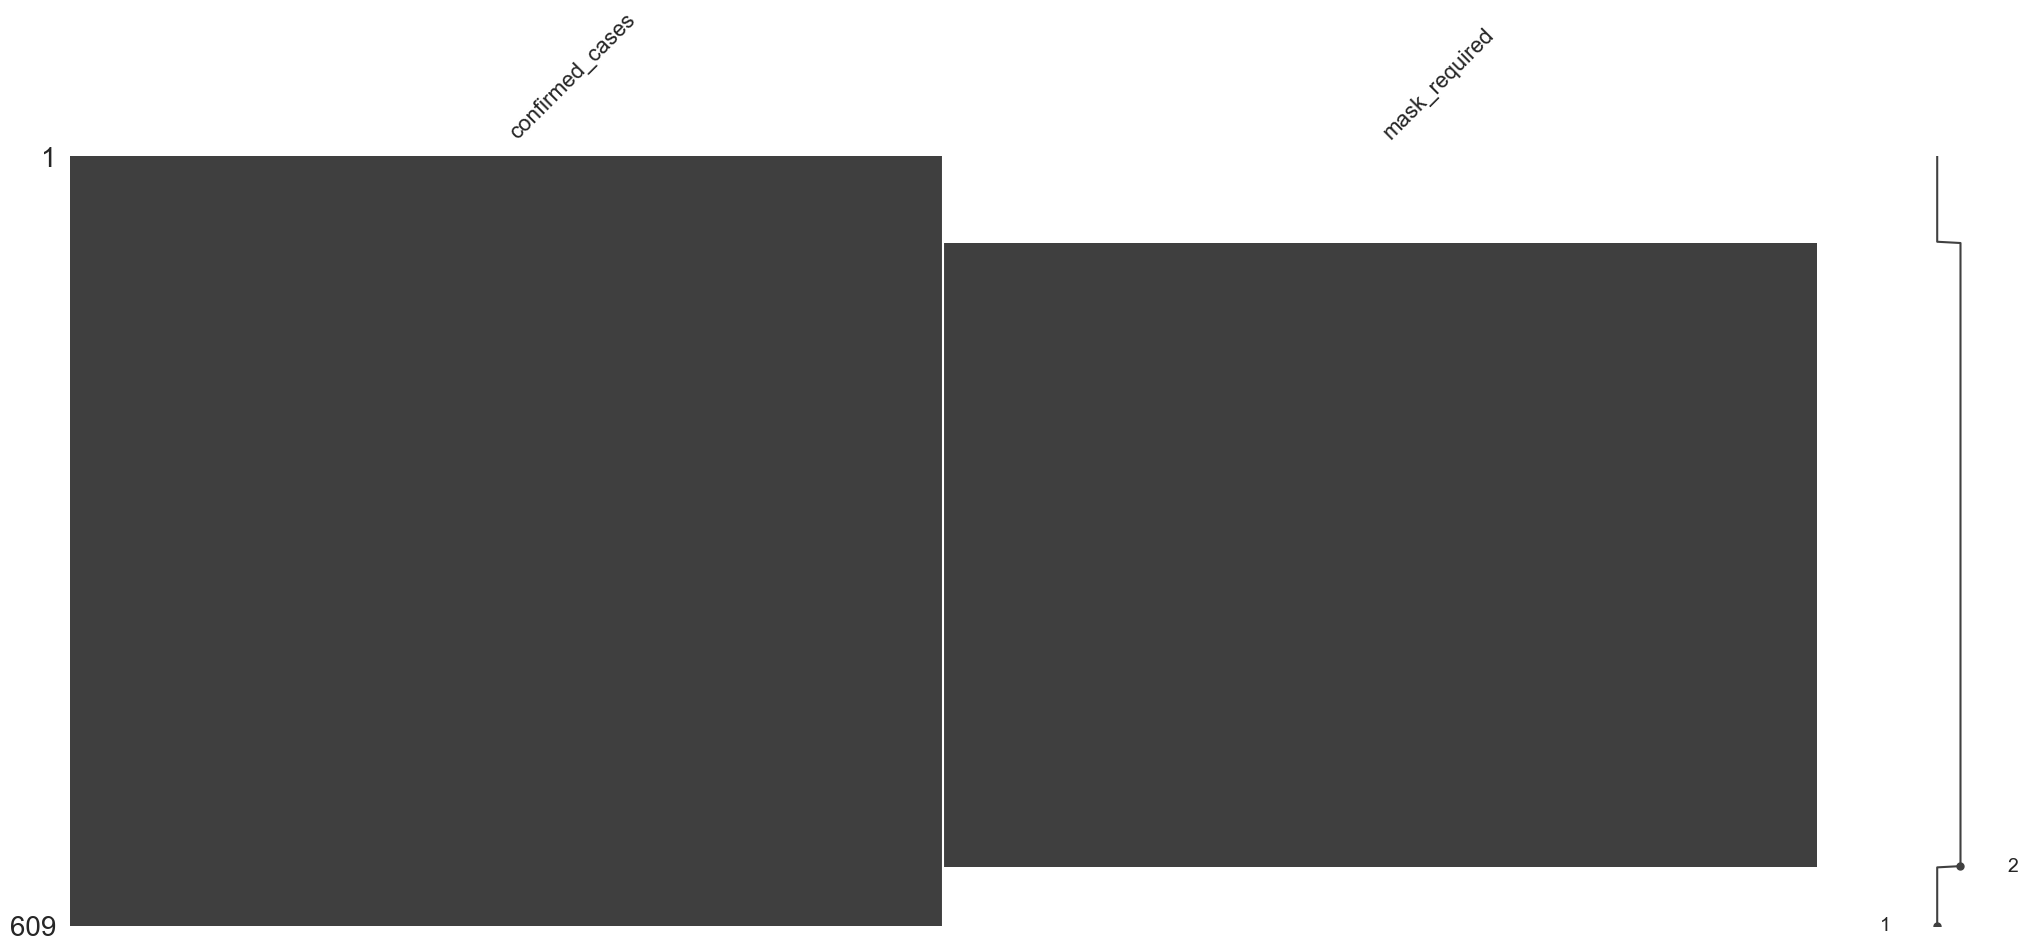

In [171]:
%matplotlib inline
msno.matrix(df_combined)

### NaN values seem to be introduced for outside the range of the Mask mandate dataset time range. We can replace above missing values with 'No' considering we don't have any info at these time points 

In [172]:
df_combined.mask_required.fillna('No',inplace=True)
df_combined.isna().sum()

confirmed_cases    0
mask_required      0
dtype: int64

## confirmed_cases column in US_raw_confirmed_cases.csv is cumulative count of COVID cases. 
## We require daily incremental count of cases for our analysis, we calculate below

In [173]:
df_combined['cases'] = df_combined['confirmed_cases'] - df_combined.shift(periods = 1)['confirmed_cases']
df_combined['cases'] = df_combined['cases'].fillna(0).astype('int64')
df_combined.head()

,confirmed_cases,mask_required,cases
date,,,
2020-02-01,2,No,0
2020-02-02,2,No,0
2020-02-03,2,No,0
2020-02-04,2,No,0
2020-02-05,2,No,0


# How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?


## A. Visualizing cumulative and incremental cases per day

(array([18322., 18383., 18444., 18506., 18567., 18628., 18687., 18748.,
        18809., 18871.]),
 [Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03'),
  Text(18748.0, 0, '2021-05'),
  Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09')])

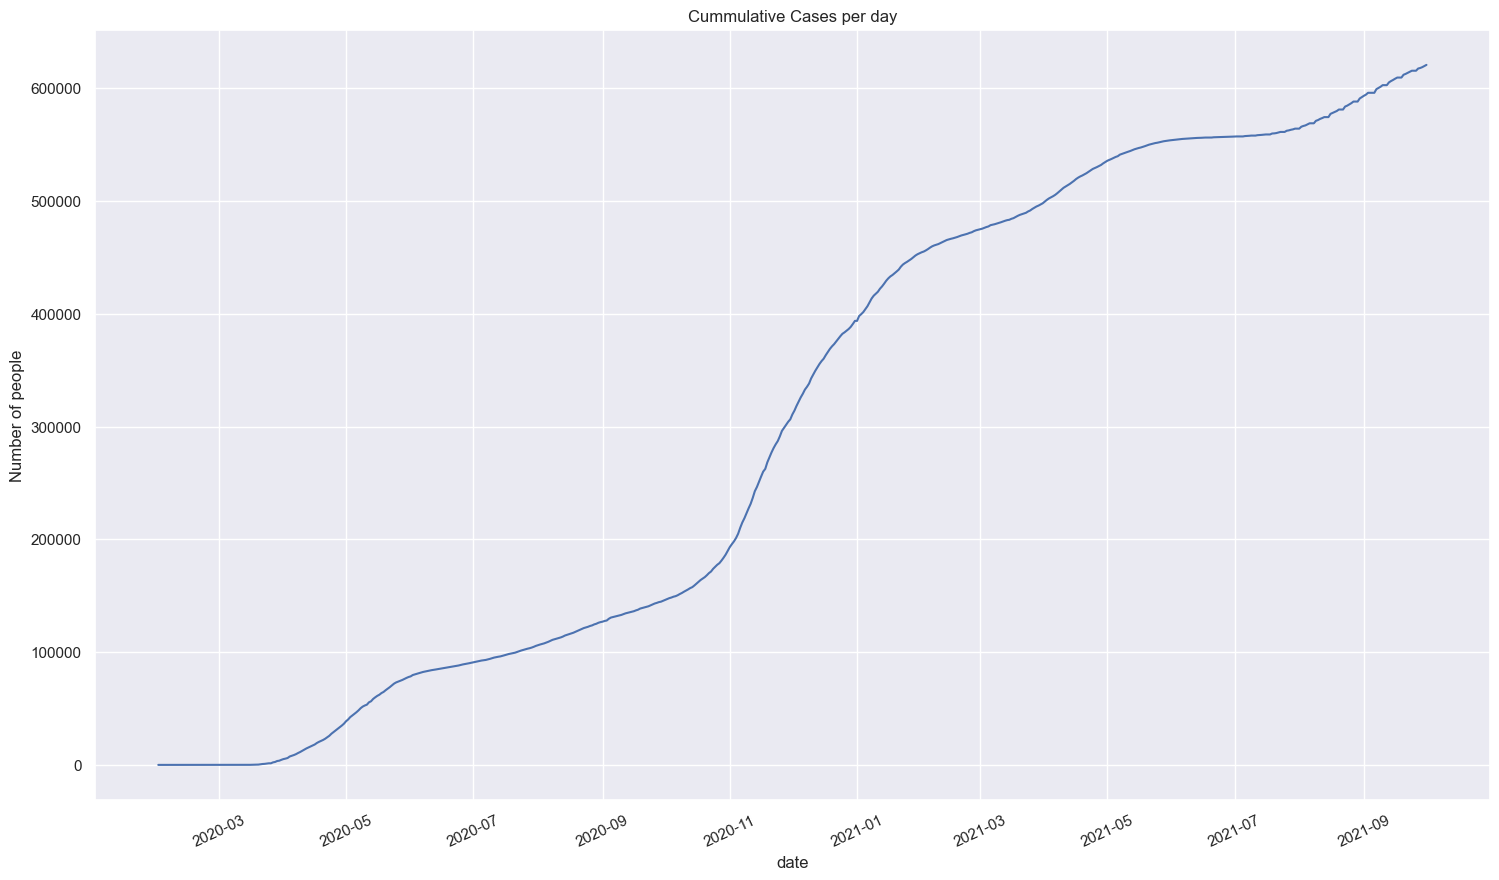

In [174]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(x = "date", y = "confirmed_cases", data = df_combined)
plt.ylabel("Number of people")
plt.title('Cummulative Cases per day')
plt.xticks(rotation = 25)

(array([18322., 18383., 18444., 18506., 18567., 18628., 18687., 18748.,
        18809., 18871.]),
 [Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03'),
  Text(18748.0, 0, '2021-05'),
  Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09')])

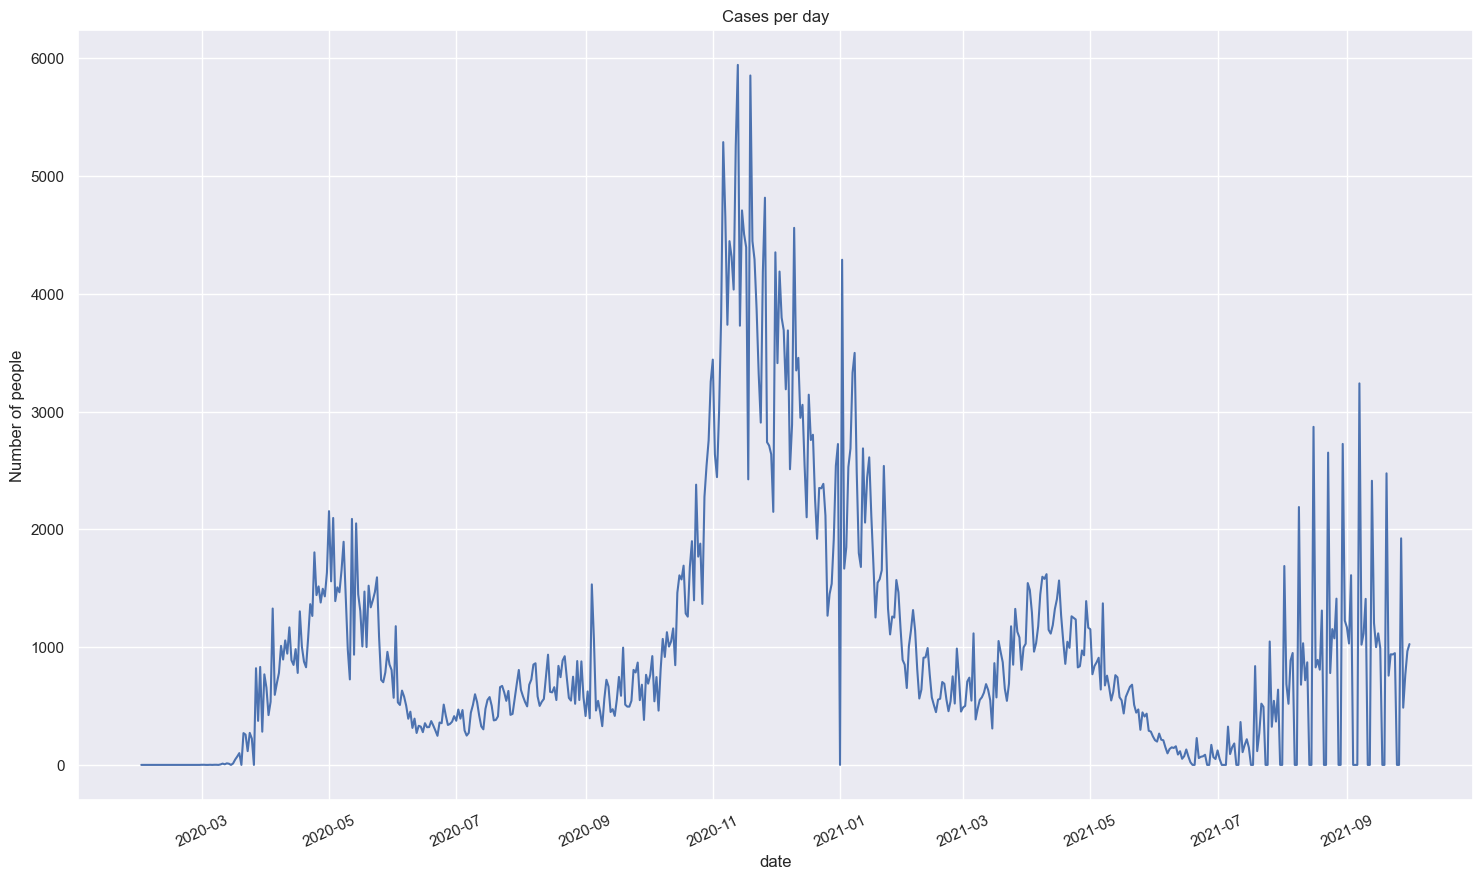

In [175]:
sns.set_theme(style="darkgrid")
# sns.lineplot(x = "date", y = "confirmed_cases", data = df_combined)
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(x = "date", y = "cases", data = df_combined)
plt.ylabel("Number of people")
plt.title('Cases per day')
plt.xticks(rotation = 25)

## This graph looks very noisy, taking a 3-day rolling average to see smoother trends 

(array([18322., 18383., 18444., 18506., 18567., 18628., 18687., 18748.,
        18809., 18871.]),
 [Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03'),
  Text(18748.0, 0, '2021-05'),
  Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09')])

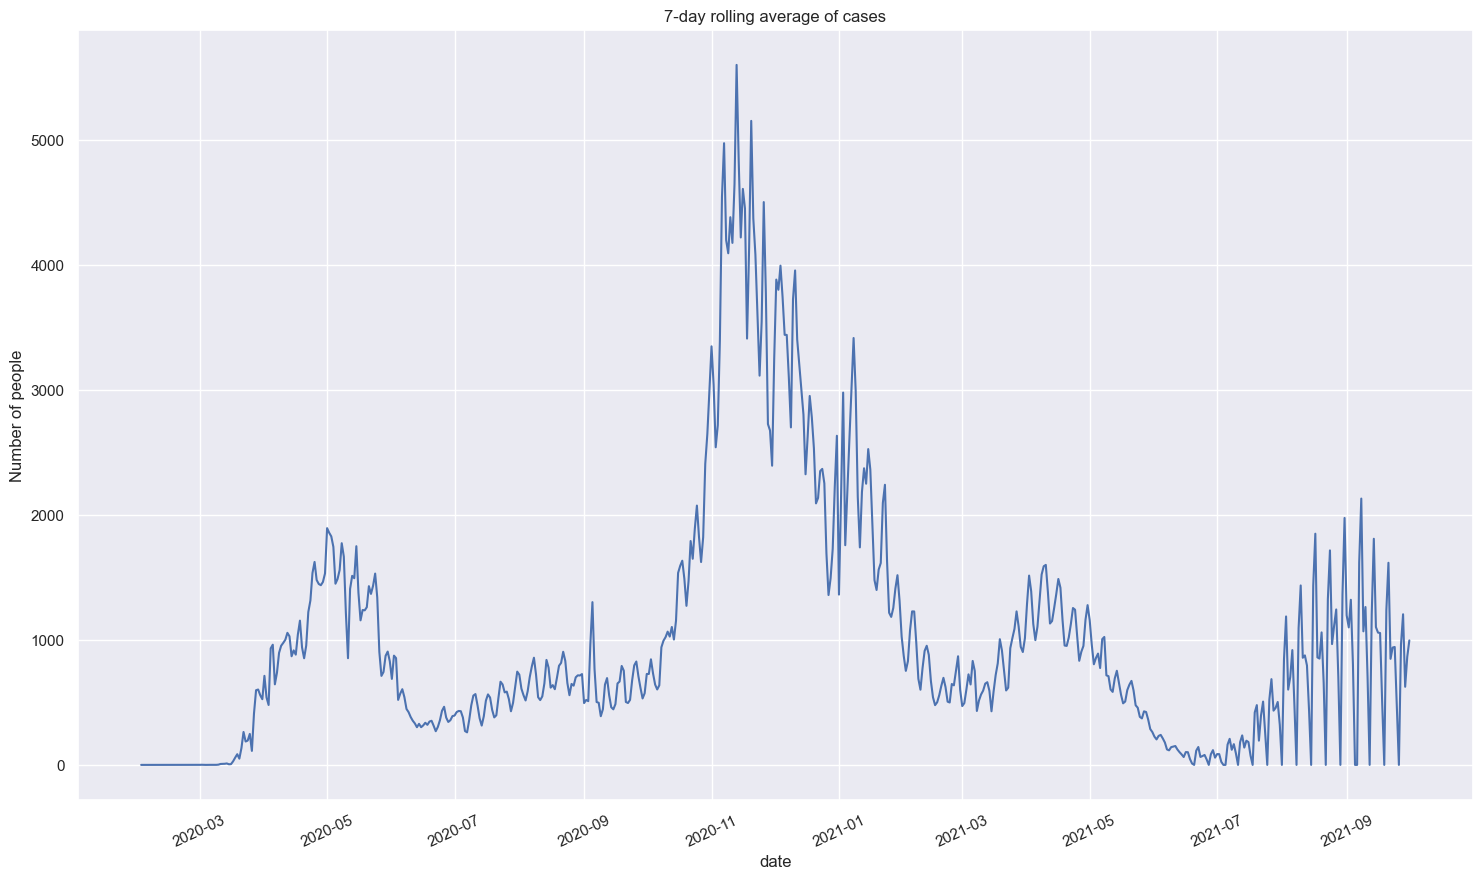

In [176]:
df_combined['cases_seven_day_rolling_avg'] = df_combined['cases'].rolling(2).mean()
sns.lineplot(x = "date", y = "cases_seven_day_rolling_avg", data = df_combined)
plt.ylabel("Number of people")
plt.title('7-day rolling average of cases')
plt.xticks(rotation = 25)

In [ ]:
df_combined


,confirmed_cases,mask_required,cases,cases_seven_day_rolling_avg
date,,,,
2020-02-01,2,No,0,NaN
2020-02-02,2,No,0,0.0
2020-02-03,2,No,0,0.0
2020-02-04,2,No,0,0.0
2020-02-05,2,No,0,0.0
...,...,...,...,...
2021-09-27,617360,No,1924,962.0
2021-09-28,617846,No,486,1205.0
2021-09-29,618610,No,764,625.0


In [ ]:
df_combined[df_combined["mask_required"]=="Yes"].tail()

,confirmed_cases,mask_required,cases,cases_seven_day_rolling_avg
date,,,,
2021-06-06,554962,Yes,149,179.0
2021-06-07,555060,Yes,98,123.5
2021-06-08,555195,Yes,135,116.5
2021-06-09,555344,Yes,149,142.0
2021-06-10,555488,Yes,144,146.5


# Step 2: Visualize

In this step we create a graph that visualizes how the course of the disease was changed by masking policies. For Cook County, we create a time series showing the changes in the derivative function of the rate of infection. The graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant.



## Including mask mandate information with derivative of rate of infection (incremental cases)

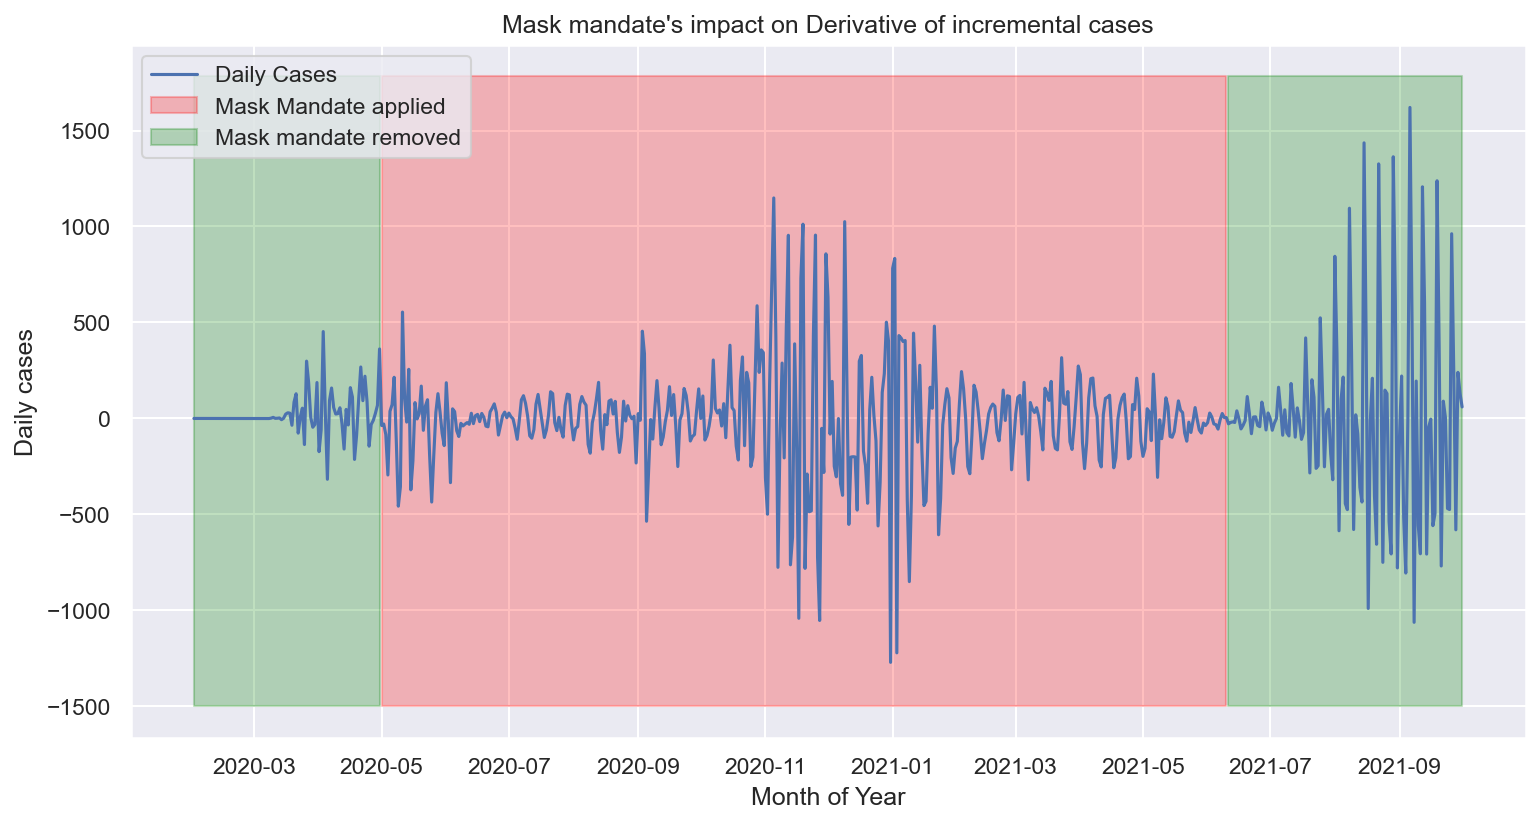

In [184]:
plt.figure(figsize=(12, 6), dpi=150)
cases = df_combined['cases']
date = df_combined.index
mask_required = df_combined['mask_required']
df_combined["derivative"] = pd.Series(np.gradient(df_combined["cases"]), df_combined.index, name='derivative').values
plt.plot(df_combined['derivative'])

plt.fill_between(date, -1500, 1.1*max(df_combined["derivative"]), where = mask_required == 'Yes', color='red', alpha=0.25)
plt.fill_between(date,  -1500, 1.1*max(df_combined["derivative"]), where = mask_required == 'No', color='green', alpha=0.25)

plt.title("Mask mandate's impact on Derivative of incremental cases")
plt.xlabel('Month of Year')
plt.ylabel('Daily cases')
plt.legend(['Daily Cases', 'Mask Mandate applied', 'Mask mandate removed'])

plt.savefig(os.path.join("..","results","timeseries_rate_of_infection_for_Cook_County_Illinois.png"))

## Including change points with derivative of infection time series

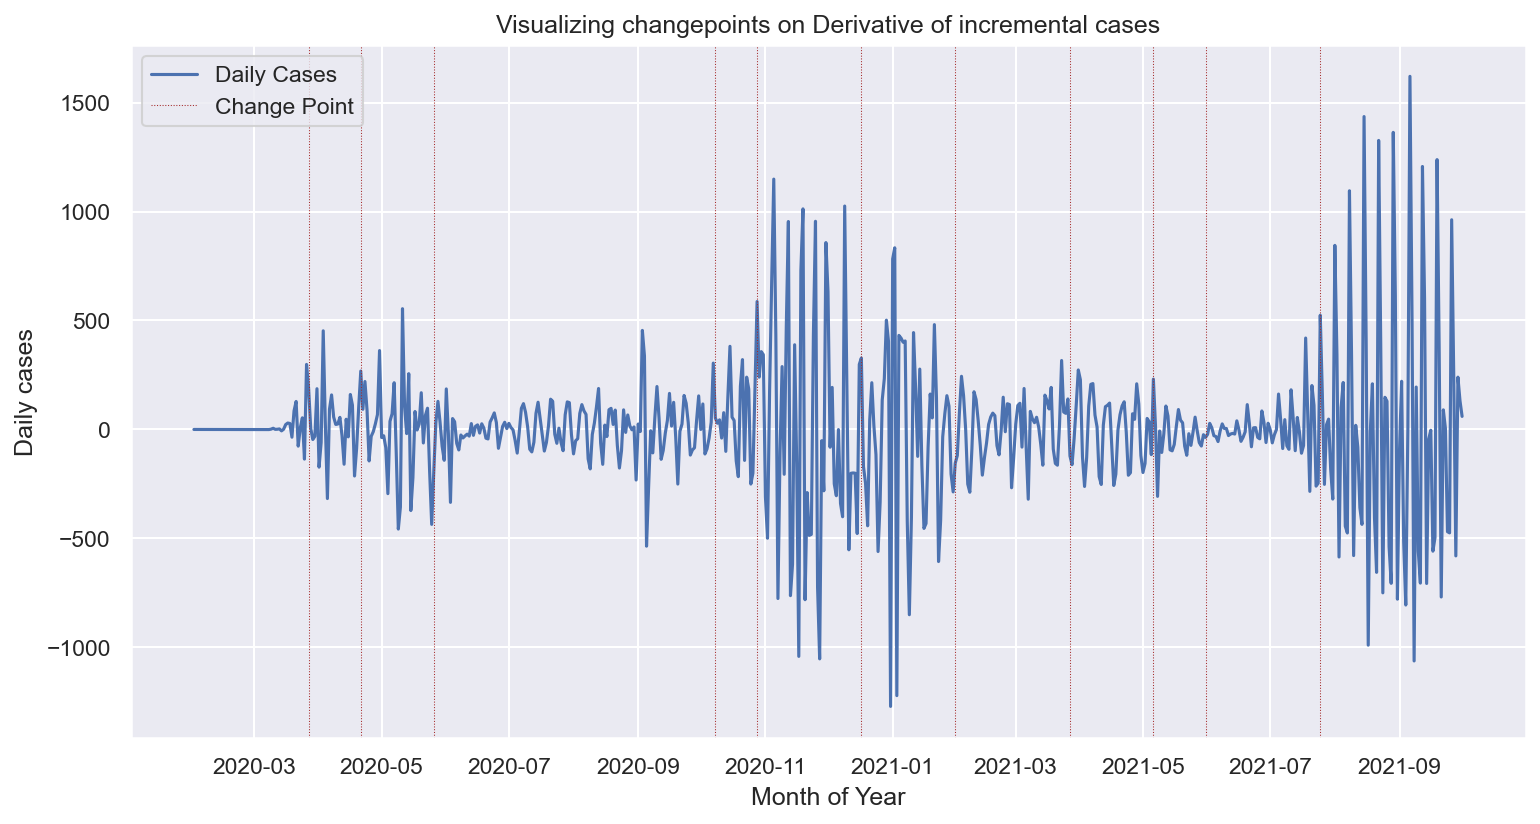

In [182]:
plt.figure(figsize=(12, 6), dpi=150)
data = np.array(df_combined['cases'])

algo = rpt.Pelt(model="rbf").fit(data)
change_location = algo.predict(pen = 5)
change_location = df_combined.iloc[change_location[:-1]].index.to_list()

df_combined["derivative"] = pd.Series(np.gradient(df_combined["cases"]), df_combined.index, name='derivative').values
plt.plot(df_combined['derivative'])

for x in change_location:
    plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')

plt.title("Visualizing changepoints on Derivative of incremental cases")
plt.xlabel('Month of Year')
plt.ylabel('Daily cases')
plt.legend(['Daily Cases', 'Change Point'])